In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# use whitegrid style
plt.style.use('seaborn-v0_8-whitegrid')
from glob import glob
import json

In [14]:
def accuracy_fn(ll_target, ll_remaining):
    max_ll = max(ll_remaining)
    return 1 if ll_target > max_ll else 0


def loglikelihood(ll_target, ll_remaining):
    return ll_target


def loglikelihood_cond(ll_target, ll_remaining):
    all_ll = ll_remaining + [ll_target]
    logsumexp = np.log(np.sum(np.exp(all_ll)))
    return ll_target - logsumexp


def loglikelihood_diff_max(ll_target, ll_remaining):
    max_ll = max(ll_remaining)
    return ll_target - max_ll


def loglikelihood_diff_mean(ll_target, ll_remaining):
    mean_ll = np.mean(ll_remaining)
    return ll_target - mean_ll


fn = {
    "accuracy": accuracy_fn,
    "loglikelihood": loglikelihood,
    "loglikelihood_cond": loglikelihood_cond,
    "loglikelihood_diff_max": loglikelihood_diff_max,
    "loglikelihood_diff_mean": loglikelihood_diff_mean,
}


def process_sample(sample, score_fn):
    ground_truth = int(sample["target"])
    ll_target = float(sample["resps"][ground_truth][0][0])
    ll_remaining = [
        float(sample["resps"][i][0][0])
        for i in range(len(sample["resps"]))
        if i != ground_truth
    ]

    score = score_fn(ll_target, ll_remaining)
    return score

## Plot graphs

In [ ]:
task = "mmlu_cais_diff"
files = glob(f"results/{task}/*/*/*.jsonl")

df = {}
for f in files:
    with open(f, "r") as infile:
        data = [json.loads(line) for line in infile]
    arc = f.split("/")[3].split("__")[-2]
    ckpt = int(f.split("/")[2].split("_")[-1])
    df[f"{arc}_{ckpt}"] = pd.DataFrame(data)

In [ ]:
results = {}

for key, value in df.items():
    arc, ckpt = key.split("_")
    results[arc] = results.get(arc, {})
    results[arc][ckpt] = {}
    for fn_name, _fn in fn.items():
        results[arc][ckpt][fn_name] = value.apply(
            process_sample, axis=1, score_fn=_fn
        ).mean()

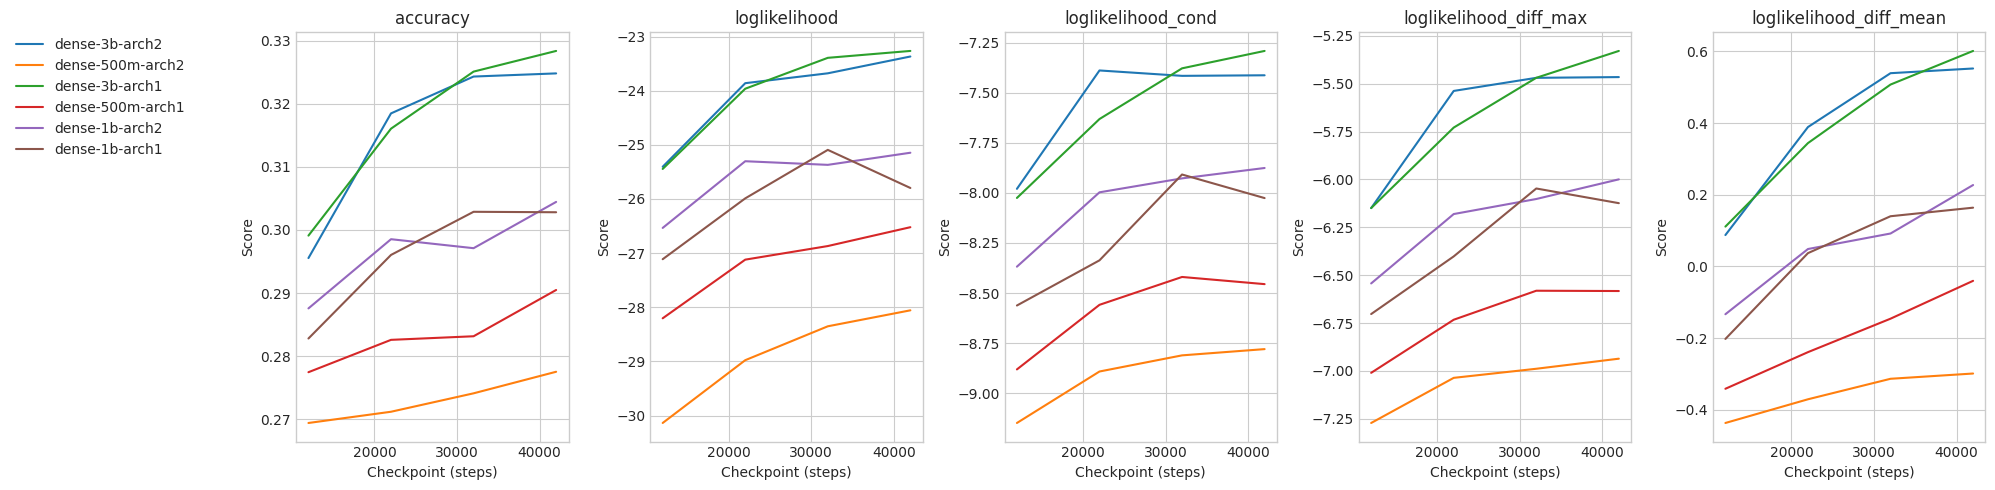

In [13]:
fig, axs = plt.subplots(nrows = 1, ncols = len(fn), figsize=(20,5))

for i, fn_name in enumerate(fn.keys()):
    for arc, value in results.items():
        ckpt_lists = sorted([int(ckpt) for ckpt in value.keys()])
        # remove ckpt < 10_000
        ckpt_lists = [ckpt for ckpt in ckpt_lists if ckpt >= 10_000]
        y = np.array([value[str(ckpt)][fn_name] for ckpt in ckpt_lists])
        axs[i].plot(
            ckpt_lists,
            y,
            label=arc
        )

    axs[i].set_xlabel("Checkpoint (steps)")
    axs[i].set_ylabel("Score")
    axs[i].set_title(fn_name)
    axs[i].grid(True)
axs[0].legend(
    bbox_to_anchor=(-1.05, 1),
    loc='upper left',
    borderaxespad=0.
)
plt.tight_layout()
plt.show()

## Evaluate each question

In [145]:
task = "mmlu_cais_diff"
files = glob(f"results/{task}/*/*/*.jsonl")

df = {}
for f in files:
    with open(f, "r") as infile:
        data = [json.loads(line) for line in infile]
    arc = f.split("/")[3].split("__")[-2]
    ckpt = int(f.split("/")[2].split("_")[-1])
    df[f"{arc}:{ckpt}"] = pd.DataFrame(data)[['doc_id', 'doc', 'resps']]
    # get id of correct answer
    df[f"{arc}:{ckpt}"]['answer_id'] = df[f"{arc}:{ckpt}"]['doc'].apply(lambda x: int(x['answer']))
    # get logprob of correct answer
    df[f"{arc}:{ckpt}"]['logprob'] = df[f"{arc}:{ckpt}"].apply(lambda row: float(row['resps'][row['answer_id']][0][0]), axis=1)
    # get length of correct answer
    df[f"{arc}:{ckpt}"]['answer_len'] = df[f"{arc}:{ckpt}"]['doc'].apply(lambda x: len(x['choices'][int(x['answer'])]))
    # drop resps column
    df[f"{arc}:{ckpt}"] = df[f"{arc}:{ckpt}"].drop(columns=['resps', 'answer_id'])

# merge based on doc_id
df_merged = df[list(df.keys())[0]]
df_merged = df_merged.rename(columns={'logprob': f'logprob_{list(df.keys())[0]}'})
for key in list(df.keys())[1:]:
    df_to_merge = df[key]
    # remove "doc" column from df_to_merge before merging
    df_to_merge = df_to_merge.drop(columns=['doc'])
    df_merged = df_merged.merge(df_to_merge, on=['doc_id'], suffixes=('', f'_{key}'))

In [168]:
# get list of arc
arcs = list(set([key.split(":")[0] for key in df.keys()]))
# get list of ckpt
ckpts = list(set([key.split(":")[1] for key in df.keys()]))
ckpts = sorted(ckpts)

score_arcs = []
for arc in arcs:
    columns = [f'logprob_{arc}:{ckpt}' for ckpt in ckpts]
    columns = [col for col in columns if col in df_merged.columns]
    y = df_merged[columns].values
    y = np.exp(y)
    increase = y[:, -1] - y[:, 0]
    increase = increase #* df_merged['answer_len']
    score_arcs.append(increase)

df_merged["score"] = np.mean(score_arcs, axis=0)

In [151]:
for i, row in df_merged.sort_values("score").head(20).iterrows():
    print(f"Score: {row['score']}")
    print(f"Question: {row['doc']['question']} Target len: {len(row['doc']['choices'][int(row['doc']['answer'])])}")
    print()

Score: -0.07254963822062209
Question: Find the characteristic of the ring Z_3 x 3Z. Target len: 1

Score: -0.05943387699998839
Question: Evaluate −2(x − 3) for x = 2. Target len: 1

Score: -0.04273041336500261
Question: For the equation: 3 x − 4(x − 2) + 6 x − 8 = 0, find the value of x. Target len: 1

Score: -0.03335282597861937
Question: What is the output of 4*1**4 in python? Target len: 1

Score: -0.031207661951235834
Question: For their first exam, students in an AP Statistics class studied an average of 4 hours with a standard deviation of 1 hour. Almost everyone did poorly on the exam, and so for the second exam every student studied 10 hours. What is the correlation between the numbers of hours students studied for each exam? Target len: 1

Score: -0.029995063618066486
Question: Consider the Lewis structures for the following molecules: CO2, CO32-, NO2-, and NO3-. Which molecule would have the shortest bonds? Target len: 3

Score: -0.02825427645746803
Question: What is the valu

Text(0, 0.5, 'Increase in Probability along training')

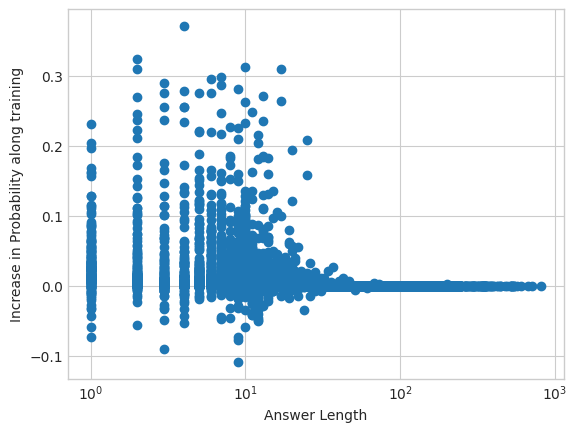

In [170]:
plt.plot(
    df_merged["answer_len"],
    df_merged["score"],
    'o'
)
plt.xscale("log")
plt.xlabel("Answer Length")
plt.ylabel("Increase in Probability along training")

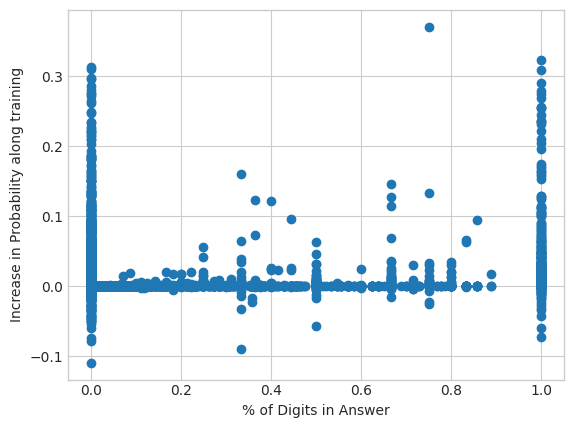

In [172]:
# count the number of digits in the answer
df_merged['num_digits'] = df_merged['doc'].apply(lambda x: sum(c.isdigit() for c in x['choices'][int(x['answer'])]))
df_merged["num_digits"] = df_merged["num_digits"] / df_merged['answer_len']

plt.scatter(
    df_merged["num_digits"][df_merged["answer_len"] > 0],
    df_merged["score"][df_merged["answer_len"] > 0],
)
plt.xlabel("% of Digits in Answer")
plt.ylabel("Increase in Probability along training")
#plt.title("Answers longer than 3 characters")
plt.show()

In [177]:
# create a a dict for the score of each doc_id
score_dict = {row['doc_id']: row['score'] for i, row in df_merged.iterrows()}

In [212]:
lower_threshold = np.quantile(list(score_dict.values()), 0.66)

In [213]:
lower_threshold

np.float64(1.4403381071189612e-06)

In [214]:
task = "mmlu_cais_diff"
files = glob(f"results/{task}/*/*/*.jsonl")

df = {}
for f in files:
    with open(f, "r") as infile:
        data = [json.loads(line) for line in infile]
    arc = f.split("/")[3].split("__")[-2]
    ckpt = int(f.split("/")[2].split("_")[-1])
    df[f"{arc}_{ckpt}"] = pd.DataFrame(data)
    df[f"{arc}_{ckpt}"]['score'] = df[f"{arc}_{ckpt}"]['doc_id'].apply(lambda x: score_dict.get(x, 0))
    df[f"{arc}_{ckpt}"] = df[f"{arc}_{ckpt}"][df[f"{arc}_{ckpt}"]['score'] > lower_threshold]
    #df[f"{arc}_{ckpt}"] = df[f"{arc}_{ckpt}"][df[f"{arc}_{ckpt}"]['score'] < scores_thresholds[1]]

In [215]:
results = {}

for key, value in df.items():
    arc, ckpt = key.split("_")
    results[arc] = results.get(arc, {})
    results[arc][ckpt] = {}
    for fn_name, _fn in fn.items():
        results[arc][ckpt][fn_name] = value.apply(
            process_sample, axis=1, score_fn=_fn
        ).mean()

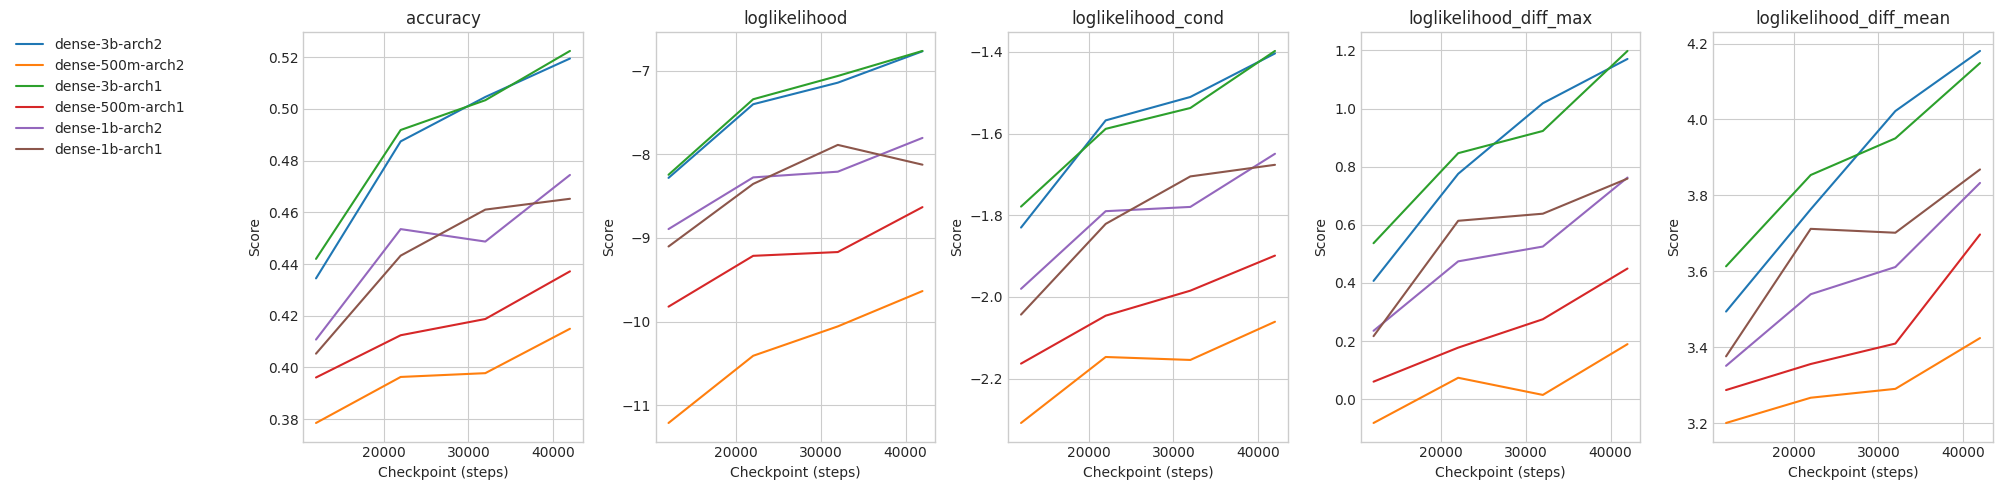

In [216]:
fig, axs = plt.subplots(nrows = 1, ncols = len(fn), figsize=(20,5))

for i, fn_name in enumerate(fn.keys()):
    for arc, value in results.items():
        ckpt_lists = sorted([int(ckpt) for ckpt in value.keys()])
        # remove ckpt < 10_000
        ckpt_lists = [ckpt for ckpt in ckpt_lists if ckpt >= 10_000]
        y = np.array([value[str(ckpt)][fn_name] for ckpt in ckpt_lists])
        axs[i].plot(
            ckpt_lists,
            y,
            label=arc
        )

    axs[i].set_xlabel("Checkpoint (steps)")
    axs[i].set_ylabel("Score")
    axs[i].set_title(fn_name)
    axs[i].grid(True)
axs[0].legend(
    bbox_to_anchor=(-1.05, 1),
    loc='upper left',
    borderaxespad=0.
)
plt.tight_layout()
plt.show()

## sending to hugging face

In [217]:
# save list of dicts as json
with open("mmlu_cais_scores.json", "w") as outfile:
    json.dump(score_dict, outfile)

In [12]:
score_dict['0']

0.02176842622983387

In [ ]:
import datasets
dataset = datasets.load_dataset("cais/mmlu", "all", split="test")

with open("mmlu_cais_scores.json", "r") as infile:
    score_dict = json.load(infile)

lower_threshold = np.quantile(list(score_dict.values()), 0.5)

# add a "score" column to the dataset based on the score_dict
def add_score(example):
    example['score'] = score_dict.get(example['id'], 0)
    return example


# add id column to the dataset based on the index
dataset = dataset.map(lambda example, idx: {'id': str(idx)}, with_indices=True)

modified_dataset = dataset.map(add_score)

# filter the dataset to keep only examples with score > lower_threshold
modified_dataset = modified_dataset.filter(lambda example: example['score'] > lower_threshold)


dataset_dev = datasets.load_dataset("cais/mmlu", "all", split="dev")


# push to hugging face
modified_dataset.push_to_hub("giovani_valdrighi/mmlu", private=True)

Map:   0%|          | 0/14042 [00:00<?, ? examples/s]

Map:   0%|          | 0/14042 [00:00<?, ? examples/s]

Filter:   0%|          | 0/14042 [00:00<?, ? examples/s]

In [ ]:
modified_dataset.push_to_hub("giovanivaldrighi/mmlu", split = "test", private=True, token="")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

README.md:   0%|          | 0.00/589 [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/giovanivaldrighi/mmlu/commit/6f5139ea319de12dd10f6a8c16dcbbf525f6a974', commit_message='Upload dataset', commit_description='', oid='6f5139ea319de12dd10f6a8c16dcbbf525f6a974', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/giovanivaldrighi/mmlu', endpoint='https://huggingface.co', repo_type='dataset', repo_id='giovanivaldrighi/mmlu'), pr_revision=None, pr_num=None)

In [ ]:
dataset_dev = datasets.load_dataset("cais/mmlu", "all", split="dev")
# create id column based on index
dataset_dev = dataset_dev.map(lambda example, idx: {'id': str(idx)}, with_indices=True)  
# make score equal to 0
dataset_dev = dataset_dev.map(lambda example: {'score': 0.0})

dataset_dev.push_to_hub("giovanivaldrighi/mmlu", split = "dev", private=True, token="")

Map:   0%|          | 0/285 [00:00<?, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/datasets/giovanivaldrighi/mmlu/commit/7143cb0589d9f0cc0c432da11986b6e13decde30', commit_message='Upload dataset', commit_description='', oid='7143cb0589d9f0cc0c432da11986b6e13decde30', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/giovanivaldrighi/mmlu', endpoint='https://huggingface.co', repo_type='dataset', repo_id='giovanivaldrighi/mmlu'), pr_revision=None, pr_num=None)

In [2]:
import datasets
dataset = datasets.load_dataset("giovanivaldrighi/mmlu", split="test")

Dataset({
    features: ['question', 'subject', 'choices', 'answer', 'id', 'score'],
    num_rows: 7021
})